# Flare ribbons detection

### Diploma thesis
#### Author: Bc. Lívia Potočňáková

## 1. ENVIROMENT SETUP

In [ ]:
import sys, os
#!git clone https://github.com/space-lab-sk/scss-net.git
#%cd scss-net
#!git pull origin main                # uncomment and start here if the repo is already cloned
!pip install -r requirements.txt
sys.path.append('../scss-net/src')

In [9]:
import glob
import zipfile
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
import numpy as np
import cv2
import pandas as pd
from mega import Mega

from skimage.morphology import skeletonize_3d
from scipy.ndimage import distance_transform_edt

In [5]:
from dsepruning import skel_pruning_DSE
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics, getSlope, intersects, getLength, getAngle, minDistance, cleanLines

#### Set variables

In [ ]:
# seed for image shuffle
SEED = 42

IMG_SIZE = 256     # resize imgs to 256x256
BATCH_SIZE = 20    # Set batch size
SEED = 42          # set seed for reproducibility
EPOCHS = 100       # Set number of epochs

In [ ]:
MODEL_NAME = "model_eruptions_5k"
model_filename = f"./{MODEL_NAME}.h5"  

### Load prepared data 
* data preparation is in "data\_preparation.ipynb" file

#### Download data and trained model

In [ ]:
mega = Mega()
m = mega.login()
print("Downloading ...")
try:
    m.download_url('https://mega.nz/file/Cvw01bSI#9LluZurr8gqOr--i1hF3EwEJ_lId4Mg3RY1hJRVtDis')
except PermissionError:
    pass
print("Model downloaded.")


In [7]:
try:
    m.download_url('https://mega.nz/file/SzBQURKJ#A7DH-57I6-c0i9-ME_KGYCZKVrKfgpwQuCFsE3sVQ0U')
except PermissionError:
    pass

print("Data downloaded.")

Data downloaded.


In [12]:
print("Unzipping ...")
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")
print("DONE")

Unzipping ...
DONE


In [92]:
# load input images
x = []
with open('./data/imgs_filtered_5k.npy', 'rb') as f:
    x = np.load(f)

# load manual segmentation masks
masks = []
with open('./data/masks_filtered_5k.npy', 'rb') as f:
    masks = np.load(f)

# load image names
imgs_names = []
with open('./data/imgs_names_filtered_5k.npy', 'rb') as f:
    imgs_names = np.load(f)

## 2. PREPARE TRAIN, TEST AND VALIDATION SETS

In [94]:
# input shape should be (256, 256, 1)
input_shape = x[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x.shape}")

Input shape: (256, 256, 1)
Train shape: (5000, 256, 256, 1)


In [95]:
# split all three arrays into train, test and val sets
x_t, x_test, y_t, y_test = train_test_split(x, masks, test_size=0.2, random_state=SEED)
x_names, x_test_names = train_test_split(imgs_names, test_size=0.2, random_state=SEED)

x_train, x_val, y_train, y_val = train_test_split(x_t, y_t, test_size=0.1, random_state=SEED)
x_train_names, x_val_names = train_test_split(x_names, test_size=0.1, random_state=SEED)

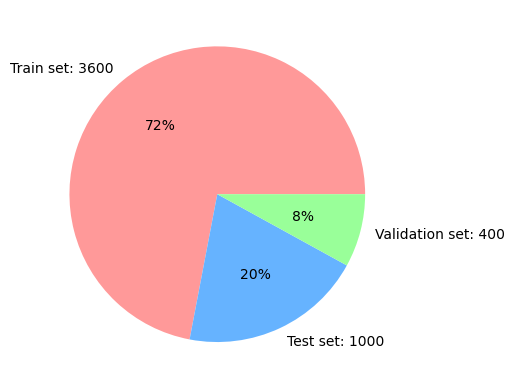

In [67]:
# display sets
data={'Train set: '+ str(len(x_train)) : len(x_train),'Test set: '+ str(len(x_test)): len(x_test),'Validation set: '+ str(len(x_val)): len(x_val)}
subject=list(data.keys())
marks=list(data.values())
colors = ['#ff9999','#66b3ff','#99ff99']
#creating pie plot
plt.pie(marks,labels=subject, autopct='%1.0f%%',colors=colors)
plt.show()

## 3. DEEP LEARNING APPROACH

### Training SCSS-net model

* The SCSS-net model architecture is defined in **../src/model_scss_net.py**. 

In [13]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE        

# Set Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)

2023-04-02 21:36:04.098527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7414 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:8b:00.0, compute capability: 6.1


2023-04-02 21:36:07.460758: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 943718400 exceeds 10% of free system memory.
2023-04-02 21:36:09.062650: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 943718400 exceeds 10% of free system memory.
2023-04-02 21:36:10.674282: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 943718400 exceeds 10% of free system memory.
2023-04-02 21:36:11.778938: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 943718400 exceeds 10% of free system memory.


Epoch 1/100


2023-04-02 21:36:15.620816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-04-02 21:36:17.964726: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-02 21:36:18.359344: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-02 21:36:18.401727: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains


Epoch 1: val_loss improved from inf to 0.10127, saving model to ./model_eruptions_5k.h5
180/180 - 100s - loss: 0.1162 - iou: 0.0293 - dice: 0.0564 - val_loss: 0.1013 - val_iou: 0.0035 - val_dice: 0.0070 - 100s/epoch - 556ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.10127 to 0.03491, saving model to ./model_eruptions_5k.h5
180/180 - 91s - loss: 0.0245 - iou: 0.1083 - dice: 0.1935 - val_loss: 0.0349 - val_iou: 0.0029 - val_dice: 0.0057 - 91s/epoch - 503ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.03491 to 0.02422, saving model to ./model_eruptions_5k.h5
180/180 - 91s - loss: 0.0115 - iou: 0.2137 - dice: 0.3497 - val_loss: 0.0242 - val_iou: 0.0027 - val_dice: 0.0054 - 91s/epoch - 504ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.02422 to 0.00769, saving model to ./model_eruptions_5k.h5
180/180 - 91s - loss: 0.0069 - iou: 0.3202 - dice: 0.4840 - val_loss: 0.0077 - val_iou: 0.2801 - val_dice: 0.4367 - 91s/epoch - 506ms/step
Epoch 5/100

Epoch 5: val_loss improve

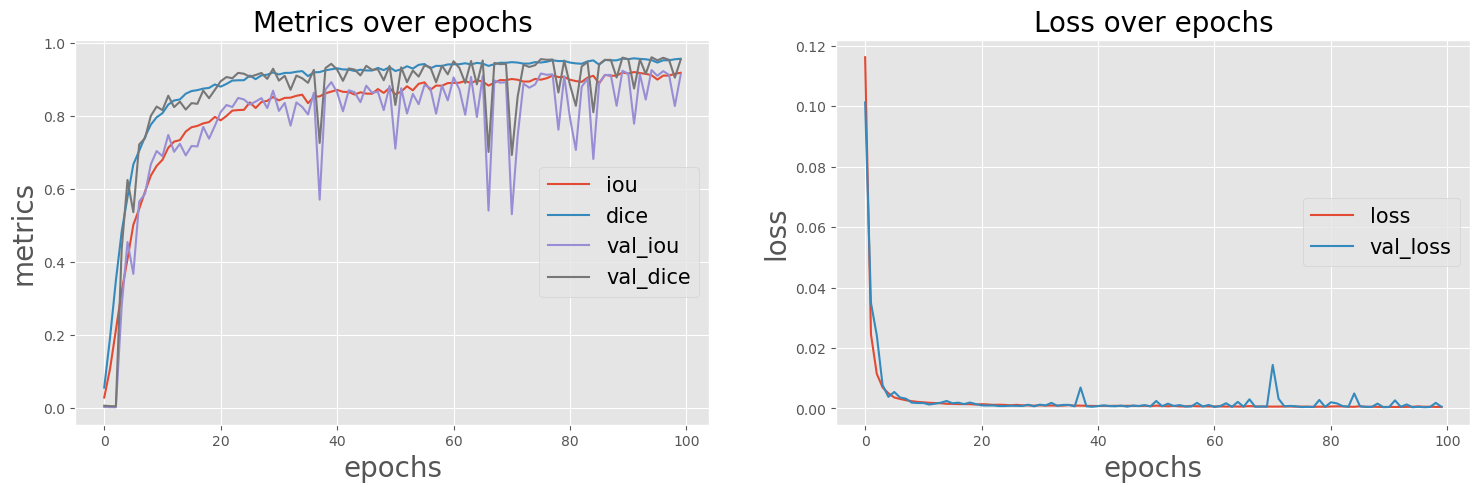

In [14]:
# Train model
history = model.fit(
    x_train,
    y_train,
    steps_per_epoch=STEPS,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint],
    verbose=2)

# Plot training history (Metrics and Loss)
plot_metrics(history).show()

### Loading model's weights

* Load the trained model

In [13]:
input_shape = x[0].shape
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

2023-04-17 08:28:16.910587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7414 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:8b:00.0, compute capability: 6.1


In [14]:
model.load_weights("./"+model_filename)

### Create predictions on test set

In [96]:
y_pred = model.predict(x_test)  

32/32 [==============================] - 6s 198ms/step


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

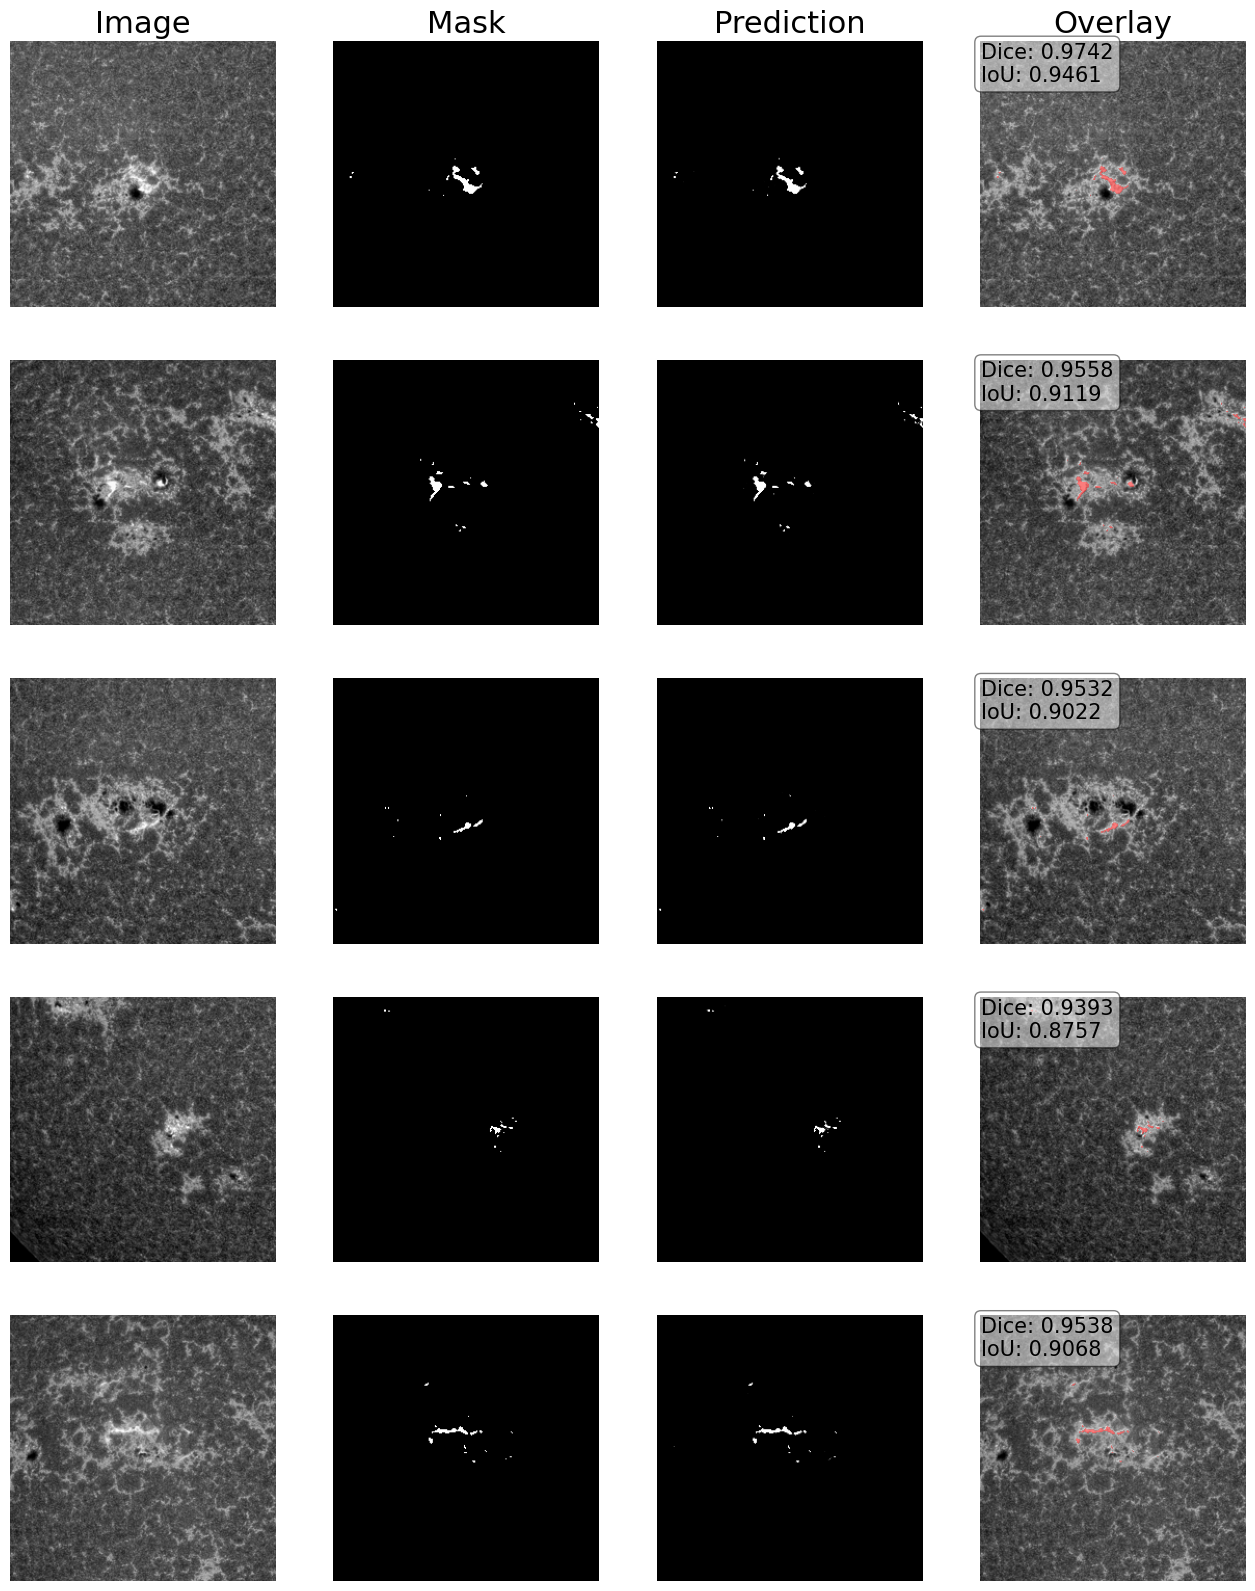

In [146]:
# display segmentation  results compared to manual masks
plot_imgs(imgs=x_test, masks =y_test, predictions=y_pred, n_imgs=5)

### Calculate metrics with and without treshold

In [155]:
y_pred_bin = np.where(y_pred>0.4, 1, 0)  # Binarize predicted values

dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

print(f"Test:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

Test:
Dice: 0.9578 Dice_tresh: 0.9766
 IoU: 0.9189 IoU_tresh: 0.9542



## DETECT PARALLEL FLARE RIBBONS

In [76]:
# create list for storing images that have parallel lines
parallel_list = []

predictions = y_pred

for image in range(len(predictions)):
    
    # use 3D skeletonization on the mask
    img = np.squeeze(predictions[image])
    skeleton = skeletonize_3d(img)
    
    # get distances from skeleton
    dist = distance_transform_edt(skeleton, return_indices=False, return_distances=True)
    
    # if there are just very small regions in the image
    if np.count_nonzero(dist >= 1) < 100:
        continue

    # create pruned skeleton by removing small branches
    pruned_skeleton = skel_pruning_DSE(skeleton, dist, 40)
  
    pruned_skeleton = np.uint8(pruned_skeleton * 255)
    
    # apply closing operation on pruned skeleton
    skel_closed = cv2.morphologyEx(pruned_skeleton, cv2.MORPH_CLOSE, kernel)

    
    lines = cv2.HoughLinesP(skel_closed, 1, np.pi/180, 5, minLineLength=10, maxLineGap=10)
    
    # in case there are less than two or too many lines found, skip it
    if lines is None or len(lines) < 2:
        continue
    
    # clean found lines
    lines_cleaned = cleanLines(lines)
    
    parallel_lines = []
    img_color = cv2.cvtColor(skel_closed, cv2.COLOR_GRAY2BGR)

    
    for i in range(len(lines_cleaned)):
        x1, y1, x2, y2 = lines_cleaned[i][0]

        length = getLength(x1, y1, x2, y2)
        if length < 20:
            continue

        slope = getSlope(x1, y1, x2, y2)
        angle = getAngle(x1, y1, x2, y2)


        for j in range(i+1, len(lines_cleaned)):
            x3, y3, x4, y4 = lines_cleaned[j][0]
            
            length2 = getLength(x3, y3, x4, y4)
            if length2 < 20:
                continue

            if intersects(x1, y1, x2, y2, x3, y3, x4, y4):
                continue

            slope2 = getSlope(x3, y3, x4, y4)
            
            # check if the lines are above themselves or next to each other
            if (y1 > max(y3,y4) and y2 > max(y3, y4)) or (y3 > max(y1, y2) and y4 > max(y1, y2)):
                if (x1 > max(x3,x4) and x2 > max(x3, x4)) or (x3 > max(x1, x2) and x4 > max(x1, x2)):
                    continue
                                
            #calculate shortest distance between the two lines
            shortest_distance = min(minDistance(x1,y1,x2,y2,x3,y3), minDistance(x1,y1,x2,y2,x4,y4),minDistance(x3,y3,x4,y4,x1,y1), minDistance(x3,y3,x4,y4,x2,y2))
            
            if abs(slope - slope2) < 10  and (slope > 0 and slope2 > 0 or slope < 0 and slope2 < 0) and (shortest_distance > 10):
                parallel_lines.append([lines_cleaned[i], lines_cleaned[j]])
                break
    
    if len(parallel_lines) == 0:
        continue
    else:
        print(len(parallel_lines),", ", image)
        parallel_list.append(x_test_names[image])
        
        
print(len(parallel_list))

2012-05-10_04-19-53_AIA1600.jp2
2012-03-10_17-45-05_AIA1600.jp2
2013-04-11_07-20-16_AIA1600.jp2
2014-12-20_00-22-40_AIA1600.jp2
2014-10-24_21-34-40_AIA1600.jp2
2014-12-20_00-33-52_AIA1600.jp2
6


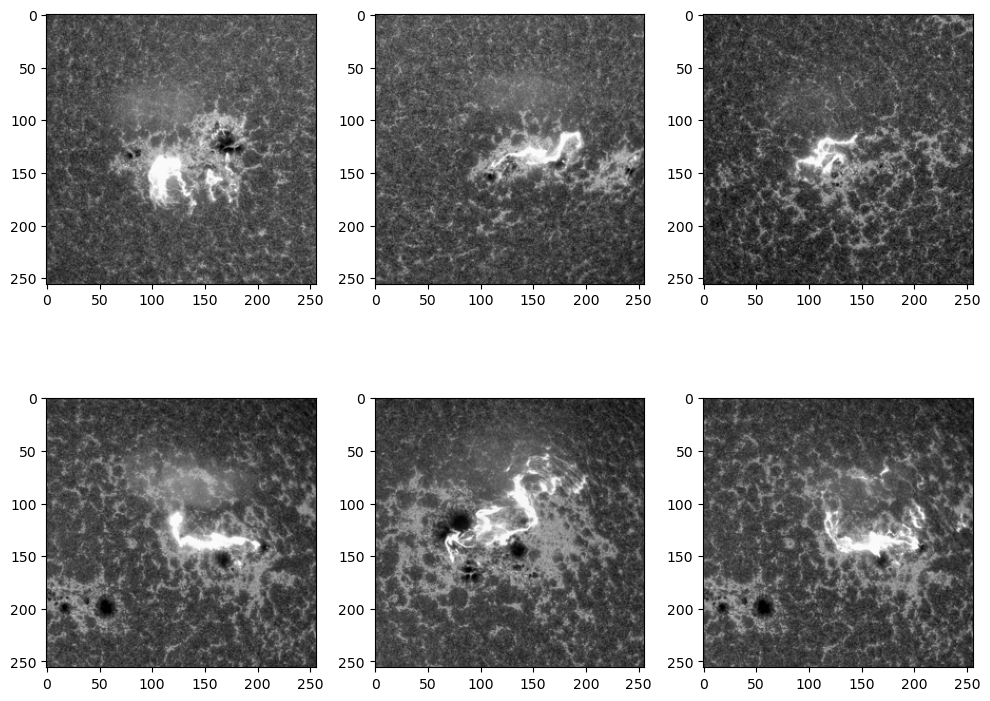

In [87]:
# display found parallel cases
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [10, 10]

for i in range(len(parallel_list)):
    plt.subplot(2, 3, i+1)
    plt.imshow(parallel_list[i], cmap="gray")
